# Solving Inverse Problems - Airplane Wing Design

When designing aircraft wings, we might be looking for a wing with a certain lift coefficient. Twinlab's inverse methods functionality can help us find a wing design with our desired lift coefficient.


In [2]:
# Third-party imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns

# Project imports
import twinlab as tl

{'username': 'jasper@digilab.co.uk', 'credits': 0}

         === TwinLab Client Initialisation ===
         Version  : 1.4.0
         User     : jasper@digilab.co.uk
         Server   : https://qisuqloa39.execute-api.eu-west-2.amazonaws.com/prod
         Key      : btUUe-IkGFOyuLun-HJAjg



### Forward Problem - Calculating Lift Coefficient of a Joukowsky Airfoil

The lift coefficient, $C_L$, is the ratio of lift produced to the dynamic pressure times the wing area. The lift coefficient can be directly calculated for Joukowsky airfoils. 

#### Joukowsky Airfoils and Joukowsky Transformations

A Joukowsky airfoil is an airfoil that has been generated by performing a Joukowsky transformation on a circle.

The Joukowsky transformation is a conformal map between a circle in the $\zeta = \chi + i\eta$ space to an airfoil in the $z = x +iy$ space (see Equation 1). This allows for us to perform calculations on the simple geometry of a circle and map the result back to the complex geometry of an airfoil.

$$
\begin{equation*}
    z = \zeta + \frac{1}{\zeta}
\tag{1}
\end{equation*}
$$

The Joukowsky transformation allows us to obtain the real ($x$) and imaginary ($y$) components of the airfoil from the real ($\chi$) and imaginary ($\eta$) components of the circle:

$$
\begin{equation*}
    x = \chi \biggl(1 + \frac{1}{\chi^2 + \eta^2}\biggr)
\tag{2}
\end{equation*}
$$
$$
\begin{equation*}
    y = \eta \biggl(1 - \frac{1}{\chi^2 + \eta^2}\biggr)
\tag{3}
\end{equation*}
$$

In [3]:
def generate_circle(center_coord, radius, n):
    """
    Generates n discrete points on a circle with a given radius and center coordinates.
    """
    thetas = np.linspace(0, 2*np.pi, n)
    chi = radius * np.cos(thetas) + center_coord[0]
    eta = radius * np.sin(thetas) + center_coord[1]

    return chi, eta


def circle_to_airfoil(chi, eta, n):
    """
    Converts the real and imaginary components of a circle to the 
    real and imaginary components of the corresponding Joukowsky airfoil.
    """
    # Components of the airfoil
    x = chi * ( 1 + ( 1 / ( chi ** 2 + eta ** 2 ) ) )
    y = eta * ( 1 - ( 1 / ( chi ** 2 + eta ** 2 ) ) )

    # Determine chord length (distance between leading edge and trailing edge)
    trailing_x = x[0]
    trailing_y = y[0]
    leading_ind = n//4 + np.abs(y[n//4:-n//4] - trailing_y).argmin()
    leading_x = x[leading_ind]
    chord_length = abs(trailing_x - leading_x)

    return x, y, chord_length

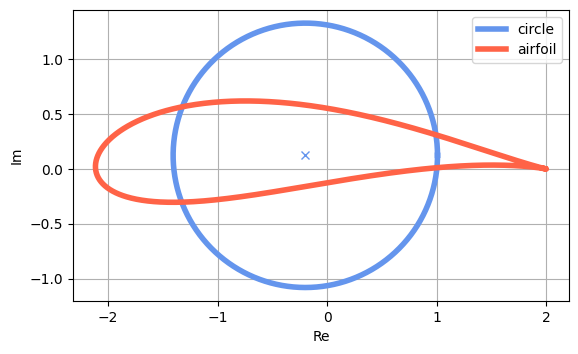

In [4]:
# Generate a sample airfoil from a circle
chi, eta = generate_circle((-0.2,0.125), 1.2065, 1000)
x, y, _ = circle_to_airfoil(chi, eta, 1000)

# Plot the circle and corresponding airfoil
fig, ax = plt.subplots()
ax.plot(chi, eta, color="cornflowerblue", lw=4, label="circle")
ax.plot(x, y, color="tomato", lw=4, label="airfoil")
ax.plot(-0.2, 0.125, 'x', color="cornflowerblue")
ax.grid()
ax.set_xlabel("Re")
ax.set_ylabel("Im")
ax.set_aspect("equal", adjustable="box")
plt.legend()
plt.show()
plt.close()

### Lift Coefficient

We want to obtain the lift coefficient, $C_L$, this can be accomplished using the following equation:

$$
\begin{equation*}
    C_L = \frac{2\,L}{\rho_{\infty}c \, U_{\infty}^2}
\tag{4}
\end{equation*}
$$

Where $L$ is the lift per unit span, $\rho_{\infty}$ is the freestream density, $c$ is the chord length, and $U_{\infty}$ is the freestream velocity.

The Kutta-Joukowski Theorem allows us to calculate lift per unit span. 
$$
\begin{equation*}
    L = \rho_{\infty} U_{\infty} \Gamma
\tag{5}
\end{equation*}
$$
Where $\Gamma$ is the circulation.

Under the Kutta condition (sharp trailing edge) the circulation, $\Gamma$, can be calculated using the following equation:
$$
\begin{equation*}
    \Gamma = 4 \, \pi \, U_{\infty} \, R \,\, \text{sin}\biggl(\alpha + \text{sin}^{-1} \biggl(\frac{\eta_{c}}{R}\biggr)\biggr)
\tag{6}
\end{equation*}
$$
Where $R$ is the radius of the circle, $\alpha$ is the angle of attack of the airfoil, and $\eta_{c}$ is the imaginary component of the circle's center.

By substituting $\Gamma$ from Equation (4) into Equation (3) and substituting the resulting $L$ into Equation (2) gives us an updated lift coefficient equation:

$$
\begin{equation*}
    C_L = 8 \, \pi \, \frac{R}{c} \, \text{sin} \biggl(\alpha + \text{sin}^{-1}\biggl(\frac{\eta_{c}}{R}\biggr)\biggr)
\tag{7}
\end{equation*}
$$

In [5]:
def get_lift_coefficient(center_coord, radius, n, alpha):
    """
    Calculates the lift coefficient of the airfoil at an attack angle, alpha, that is
    Joukowski transformed from the n-point circle with the given radius and center coordinates.
    """
    chi, eta = generate_circle(center_coord, radius, n)
    _, _, chord_len = circle_to_airfoil(chi, eta, n)
    return 8 * np.pi * (radius/chord_len) * np.sin( alpha + np.arcsin( center_coord[1] / radius ) )

In [6]:
# Get the lift coefficient of the sample airfoil with no angle of attack.
lift_coefficient = get_lift_coefficient((-0.2,0.125), 1.2065, 1000, 0)
lift_coefficient

0.7663180968520446

## Inverse Problem - Finding a Joukowski Airfoil with the Desired Lift Coefficient

### Generate the Dataset
To solve the inverse problem we must first generate a dataset of circles and the lift coefficient of their corresponding airfoils. This is done by solving the forward problem with different inputs. 

To satisfy the Kutta condition, an airfoil must have a sharp trailing edge. This is achieved by transforming a circle that intersects $\zeta = 1 + 0i$ and encircles $\zeta = -1 + 0i$. So the radius, $R$, of a circle given its center coordinates $(\chi_c, \eta_c)$ must satisfy Equation (8). To obtain reasonably shaped airfoils we will place the further restriction of $-0.25 \leq \chi_c \leq -0.075$ and $0.075 \leq \eta_c \leq 0.25$ 

$$
\begin{equation*}
    R = \sqrt{(1-\chi_c)^2+\eta_c^2}
\tag{8}
\end{equation*}
$$

In [7]:
# Get the necessary radius for the given circle center
def get_radius(chi_c, eta_c):
    """
    Determines the radius for a circle with center coordinates (chi_c, eta_c) so that
    it encircles zeta=-1 and intersects zeta=1.
    """
    return np.sqrt((1 - chi_c)**2 + eta_c**2)

# Generate the dataset
def generate_dataset(n):
    """
    Generate a datset of n datapoints containing the circle center coordinates,
    circle radius, and corresponding airfoil lift coefficient.
    """
    num_points = round(np.sqrt(n))
    chi_c_vals = np.linspace(-0.25, -0.075, num_points)
    eta_c_vals = np.linspace(0.075, 0.25, num_points)
    data = []
    i = 0
    for chi_c in chi_c_vals:
        for eta_c in eta_c_vals:
            radius = get_radius(chi_c, eta_c)
            lift_coefficient = get_lift_coefficient((chi_c, eta_c), radius, 1000, 0)
            data.append([chi_c, eta_c, lift_coefficient])
            i += 1

    dataset = pd.DataFrame(data=data, columns=["chi_c", "eta_c", "lift coeff"])
    return dataset
    

In [8]:
# Generate a dataset
df = generate_dataset(625)
display(df)

,chi_c,eta_c,lift coeff
0,-0.250,0.075000,0.452992
1,-0.250,0.082292,0.497169
2,-0.250,0.089583,0.541382
3,-0.250,0.096875,0.585591
4,-0.250,0.104167,0.629881
...,...,...,...
620,-0.075,0.220833,1.395832
621,-0.075,0.228125,1.652891
622,-0.075,0.235417,1.699194
623,-0.075,0.242708,1.745235


In [9]:
# Model parameters
dataset_id = "wing-inverse"
campaign_id = "wing-inverse"

# Send the experimental dataset to the cloud
tl.upload_dataset(df, dataset_id, verbose=True)

Dataframe is uploading.
Processing dataset.
Dataset wing-inverse was processed.


### Training the Model
Next we establish our training parameters and train our model on the dataset we produced.

In [10]:
# Training parameters
params = {
    "dataset_id": dataset_id,
    "inputs" : ["chi_c", "eta_c"],
    "outputs": ["lift coeff"],
    "test_train_ratio": 0.8,
}

# Train the model in the cloud
tl.train_campaign(params, campaign_id, verbose=True)

Model wing-inverse has begun training.


### Solve the Inverse Problem

Suppose we want to find an airfoil that has a lift coefficient of $1.33 \pm 0.005$ at zero angle of attack.

In [11]:
# Solve the inverse problem
desired_coeff = pd.DataFrame({"lift coeff": [1.33]})
tolerance = pd.DataFrame({"lift coeff": [0.005]})

inverse_df = tl.solve_inverse_campaign(campaign_id, desired_coeff, tolerance, return_summary=False, verbose=True, debug=True)

AttributeError: module 'twinlab' has no attribute 'solve_inverse_campaign'

In [ ]:
# Plot the posterior distribution
sns.jointplot(x=inverse_df["chi_c"], y=inverse_df["eta_c"], kind="kde", cmap="viridis", fill=True)
plt.plot(-0.09, 0.155, 'x', color="black")
plt.plot(-0.225, 0.217, 'x', color="black")
plt.xlabel(r"$\chi_c$")
plt.ylabel(r"$\eta_c$")
plt.grid()
plt.show()
plt.close()

In [ ]:
# Generate airfoils from candidate solutions
chi1_c = -0.09
eta1_c = 0.155
chi1, eta1 = generate_circle((chi1_c, eta1_c), get_radius(chi1_c, eta1_c), 1000)
x1, y1, _ = circle_to_airfoil(chi1, eta1, 1000)

chi2_c = -0.225
eta2_c = 0.217
chi2, eta2 = generate_circle((chi2_c, eta2_c), get_radius(chi2_c, eta2_c), 1000)
x2, y2, _ = circle_to_airfoil(chi1, eta1, 1000)

# Plot the circle and corresponding airfoil
fig, ax = plt.subplots(1,2, figsize=(14,7))
ax[0].plot(chi1, eta1, color="cornflowerblue", lw=4, label="circle")
ax[0].plot(x1, y1, color="tomato", lw=4, label="airfoil")
ax[0].plot(chi1_c, eta1_c, 'x', color="cornflowerblue")
ax[0].grid()
# ax[0].set_xlabel("Re")
# ax[0].set_ylabel("Im")
ax[0].set_aspect("equal", adjustable="box")

ax[1].plot(chi2, eta2, color="cornflowerblue", lw=4, label="circle")
ax[1].plot(x2, y2, color="tomato", lw=4, label="airfoil")
ax[1].plot(chi2_c, eta2_c, 'x', color="cornflowerblue")
ax[1].grid()
# ax[1].set_xlabel("Re")
# ax[1].set_ylabel("Im")
ax[1].set_aspect("equal", adjustable="box")

# plt.legend()
plt.show()
plt.close()

### Validate Result

Pass the solution to the inverse problem through the forward problem to validate our result.

In [ ]:
# High density at approximately (-0.09, 0.155)
print(f"Circle Center ({chi1_c}, {eta1_c})")
radius1 = get_radius(chi1_c, eta1_c)
actual = get_lift_coefficient((chi1_c, eta1_c), radius1, 1000, 0)

difference = abs(desired_coeff["lift coeff"][0]- actual)  

if difference <= tolerance["lift coeff"][0]:
    print(f"Success! The difference between the inverse model lift coefficient ({round(actual,5)}) and the forward computed lift coefficient ({desired_coeff['lift coeff'][0]}) is {round(difference, 5)} which is less than the tolerance of {tolerance['lift coeff'][0]}.")
else:
    print(f"Something went wrong! The difference between the inverse model lift coefficient ({round(actual,5)}) and the forward computed lift coefficient ({desired_coeff['lift coeff'][0]}) is {round(difference, 5)} which is greater than the tolerance of {tolerance['lift coeff'][0]}.")
print("")
# Density highest at approximately (-0.225, 0.217)
print(f"Circle Center ({chi2_c}, {eta2_c})")
radius2 = get_radius(chi2_c, eta2_c)
actual = get_lift_coefficient((chi2_c, eta2_c), radius2, 1000, 0)

difference = abs(desired_coeff["lift coeff"][0]- actual)  

if difference <= tolerance["lift coeff"][0]:
    print(f"Success! The difference between the inverse model lift coefficient ({round(actual,5)}) and the desired lift coefficient ({desired_coeff['lift coeff'][0]}) is {round(difference, 5)} which is less than the tolerance of {tolerance['lift coeff'][0]}.")
else:
    print(f"Something went wrong! The difference between the inverse model lift coefficient ({round(actual,5)}) and the desired lift coefficient ({desired_coeff['lift coeff'][0]}) is {round(difference, 5)} which is greater than the tolerance of {tolerance['lift coeff'][0]}.")

## Finishing up 

This section covers how to delete your trained model and dataset from the cloud. Note that you don't need to delete your model and data to rerun a campaign or dataset of the same name--if, say, you rerun the functions above as-is, with no name changes, will simply overwrite your existing model and dataset on the Cloud.

In [ ]:
# Delete campaign and dataset if necessary
tl.delete_campaign(campaign_id, verbose=True)
tl.delete_dataset(dataset_id, verbose=True)